https://docs.solcore.solar/en/latest/Examples/example_optics_comparison.html

In [5]:
from solcore import config
print(config)

[Configuration]
version = 5.9.1
welcome_message = 1
verbose_loading = 1

[Units]
default = SOLCORE_ROOT/units_system/Default_units.txt

[Parameters]
calculables = SOLCORE_ROOT/parameter_system/calculable_parameters.txt
adachi_binaries = SOLCORE_ROOT/material_data/Adachi/binaries.txt
adachi_compounds = SOLCORE_ROOT/material_data/Adachi/ternaries.txt
vurgaftman_binaries = SOLCORE_ROOT/material_data/Vurgaftman/binaries.txt
vurgaftman_compounds = SOLCORE_ROOT/material_data/Vurgaftman/ternaries.txt
levinshtein_groupIV = SOLCORE_ROOT/material_data/Levinshtein/GroupIV.txt

[Materials]
GaAs = SOLCORE_ROOT/material_data/GaAs-Material
InSb = SOLCORE_ROOT/material_data/InSb-Material
GaSb = SOLCORE_ROOT/material_data/GaSb-Material
AlAs = SOLCORE_ROOT/material_data/AlAs-Material
AlGaAs = SOLCORE_ROOT/material_data/AlGaAs-Material
InGaAs = SOLCORE_ROOT/material_data/InGaAs-Material
GaInSb = SOLCORE_ROOT/material_data/InGaSb-Material
Ge = SOLCORE_ROOT/material_data/Ge-Material
Si = SOLCORE_ROOT/mater

Comparison of Solcore’s optical models

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from solcore import si, material
from solcore.structure import Junction, Layer
from solcore.solar_cell import SolarCell
from solcore.solar_cell_solver import solar_cell_solver, default_options
from solcore.light_source import LightSource
from solcore.constants import vacuum_permittivity
from solcore.absorption_calculator import RCWASolverError

Treating layer(s) 3 incoherently
Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...
Solving QE of the solar cell...
Treating layer(s) 23 incoherently
Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...
Treating layer(s) 24 incoherently
Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...
Solving QE of the solar cell...
Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...


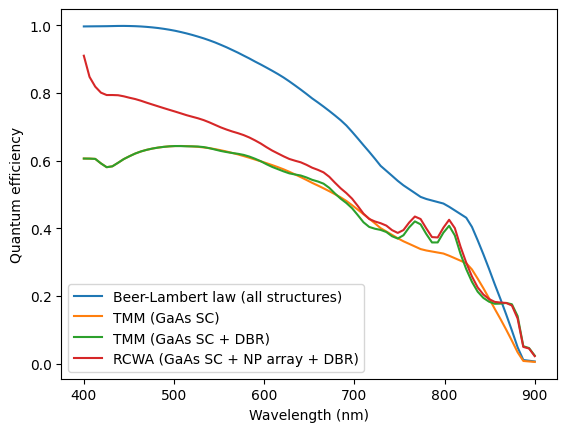

In [7]:
# user options
T = 298
wl = si(np.linspace(400, 900, 80), 'nm')
light_source = LightSource(source_type='standard', version='AM1.5g', x=wl,
                           output_units='photon_flux_per_m', concentration=1)
opts = default_options
opts.wavelength, opts.no_back_reflection, opts.size, opts.light_source, opts.T_ambient = \
    wl, False, ((400, 0), (0, 400)), light_source, T
opts.recalculate_absorption = True
# The size of the unit cell for the RCWA structure is 400 x 400 nm

# Defining all the materials we need
Air = material('Air')(T=T)
p_GaAs = material('GaAs')(T=T, Na=si('4e18cm-3'))  # for the GaAs cell emitter
n_GaAs = material('GaAs')(T=T, Nd=si('2e17cm-3'))  # for the GaAs cell base
AlAs, GaAs = material('AlAs')(T=T), material('GaAs')(T=T)  # for the DBR
SiO2 = material('SiO2', sopra=True)(T=T)  # for the spacer layer
TiO2 = material('TiO2', sopra=True)(T=T)  # for the nanoparticles

# some parameters for the QE solver
for mat in [n_GaAs, p_GaAs]:
    mat.hole_mobility, mat.electron_mobility, mat.permittivity = 3.4e-3, 5e-2, 9 * vacuum_permittivity
    n_GaAs.hole_diffusion_length, p_GaAs.electron_diffusion_length = si("500nm"), si("5um")

# Define the different parts of the structure we will use. For the GaAs junction, we use the depletion approximation
GaAs_junction = [Junction([Layer(width=si('100nm'), material=p_GaAs, role="emitter"),
                           Layer(width=si('400nm'), material=n_GaAs, role="base")], T=T, kind='DA')]

# this creates 10 repetitions of the AlAs and GaAs layers, to make the DBR structure
DBR = 10 * [Layer(width=si("73nm"), material=AlAs), Layer(width=si("60nm"), material=GaAs)]
# The layer with nanoparticles
NP_layer = [Layer(si('50nm'), Air, geometry=[{'type': 'circle', 'mat': TiO2, 'center': (200, 200),
                                              'radius': 50}])]
substrate = [Layer(width=si('50um'), material=GaAs)]
spacer = [Layer(width=si('25nm'), material=SiO2)]

# --------------------------------------------------------------------------
# solar cell with SiO2 coating
solar_cell = SolarCell(spacer + GaAs_junction + substrate)

opts.optics_method = 'TMM'
solar_cell_solver(solar_cell, 'qe', opts)
TMM_EQE = solar_cell[1].eqe(opts.wavelength)

opts.optics_method = 'BL'
solar_cell_solver(solar_cell, 'qe', opts)
BL_EQE = solar_cell[1].eqe(opts.wavelength)

# --------------------------------------------------------------------------
# as above, with a DBR on the back
solar_cell = SolarCell(spacer + GaAs_junction + DBR + substrate)

opts.optics_method = 'TMM'
solar_cell_solver(solar_cell, 'qe', opts)
TMM_EQE_DBR = solar_cell[1].eqe(opts.wavelength)

# --------------------------------------------------------------------------
# cell with TiO2 nanocylinder array on the front
solar_cell = SolarCell(NP_layer + spacer + GaAs_junction + DBR + substrate)

opts.optics_method = 'TMM'
solar_cell_solver(solar_cell, 'qe', opts)
TMM_EQE_NP = solar_cell[2].eqe(opts.wavelength)

opts.optics_method = 'BL'
solar_cell_solver(solar_cell, 'qe', opts)
BL_EQE_NP = solar_cell[2].eqe(opts.wavelength)

try:
    opts.optics_method = 'RCWA'
    opts.orders = 19  # number of diffraction orders to keep in the RCWA solver
    solar_cell_solver(solar_cell, 'qe', opts)
    RCWA_EQE_NP = solar_cell[2].eqe(opts.wavelength)
    RCWA_legend = 'RCWA (GaAs SC + NP array + DBR)'
except RCWASolverError:
    RCWA_EQE_NP = np.zeros_like(BL_EQE_NP)
    RCWA_legend = '(RCWA solver S4 not available)'


plt.figure()
plt.plot(wl * 1e9, BL_EQE_NP, wl * 1e9, TMM_EQE, wl * 1e9, TMM_EQE_DBR, wl * 1e9, RCWA_EQE_NP)
# plt.plot(wl * 1e9, BL_EQE_NP, wl * 1e9, TMM_EQE, wl * 1e9, TMM_EQE_DBR)
plt.legend(labels=['Beer-Lambert law (all structures)', 'TMM (GaAs SC)', 'TMM (GaAs SC + DBR)',
                   RCWA_legend])
# plt.legend(labels=['Beer-Lambert law (all structures)', 'TMM (GaAs SC)', 'TMM (GaAs SC + DBR)'])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Quantum efficiency")
plt.show()